# COVID 19 XRAY IMAGE CLASSIFICATION

In [1]:
import os
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


### Common functions

### Class wheighting

In [2]:
drive.mount('/content/drive')

def load_images_and_labels(paths, labels):
    images = []
    image_labels = []

    for i, path in enumerate(paths):
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            image_labels.append(labels[i])

    return np.array(images), np.array(image_labels)

# These paths may change for each tester
dataset_paths = ['/content/drive/My Drive/xrays/HEALTHY',
                 '/content/drive/My Drive/xrays/COVID'
        ]

labels = [0,1]

images, image_labels = load_images_and_labels(dataset_paths, labels)

Mounted at /content/drive


In [3]:
images = images / 255.0
label_to_index = dict((name, index) for index, name in enumerate(labels))
image_labels = np.array([label_to_index[label] for label in image_labels])


In [4]:
labels = [0,1]

def convert_to_rgb(image_paths, labels):
    images = []
    image_labels = []

    for path, label in zip(image_paths, labels):
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path) and not filename.startswith('.'):
                img = load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                img = img_to_array(img)
                img = np.repeat(img, 3, axis=2)
                images.append(img)
                image_labels.append(label)

    return np.array(images), np.array(image_labels)

images, image_labels = convert_to_rgb(dataset_paths,labels)


In [5]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(
    images, image_labels, test_size=test_size, random_state=42
)
print(Y_train)
print(Y_test)

[1 1 1 ... 1 1 0]
[0 1 0 ... 0 1 1]


In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Early stoping technique
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=x)
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history1 = model1.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

model1.save('vgg19_class_weight_model.h5')

with open('vgg19_class_weight_history.json', 'w') as f:
    json.dump(history1.history, f)

In [12]:
from google.colab import files

files.download('vgg19_class_weight_history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp vgg19_class_weight_model.h5 "/content/drive/My Drive/"

In [ ]:
!cp vgg19_class_weight_history.json "/content/drive/My Drive/"

In [13]:
def plot_loss(history):
  epochs = list(range(1, len(history.history['loss']) + 1))
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  df = pd.DataFrame({
      'Epoch': epochs * 2,
      'Loss': loss + val_loss,
      'Type': ['Training Loss'] * len(loss) + ['Validation Loss'] * len(val_loss)
  })

  fig = px.line(
      df,
      x='Epoch',
      y='Loss',
      color='Type',
      labels={'Epoch': 'Epoch', 'Loss': 'Loss'},
      title='Training and Validation Loss'
  )
  fig.update_layout(legend_title_text='Loss Type')
  fig.update_traces(mode='lines', hoverinfo='all', line=dict(width=2))

  fig.show()

In [14]:
plot_loss(history=history1)

In [15]:
import pandas as pd
import plotly.express as px

def plot_accuracy(history):
    epochs = list(range(1, len(history.history['accuracy']) + 1))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    df = pd.DataFrame({
        'Epoch': epochs * 2,
        'Accuracy': accuracy + val_accuracy,
        'Type': ['Training Accuracy'] * len(accuracy) + ['Validation Accuracy'] * len(val_accuracy)
    })

    fig = px.line(
        df,
        x='Epoch',
        y='Accuracy',
        color='Type',
        labels={'Epoch': 'Epoch', 'Accuracy': 'Accuracy'},
        title='Training and Validation Accuracy'
    )
    fig.update_layout(legend_title_text='Metric Type')
    fig.update_traces(mode='lines', hoverinfo='all', line=dict(width=2))

    fig.show()


In [16]:
plot_accuracy(history1)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics_val(model):
  print("Metrics for validation set:")
  Y_pred_in = model.predict(X_test)
  Y_pred = (Y_pred_in > 0.5).astype(int)

  accuracy = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)  # Use 'micro', 'macro', or 'weighted' for multi-class
  recall = recall_score(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")


In [18]:
print_metrics_val(model=model1)

Metrics for validation set:
33/33 [==============================] - 2s 70ms/step
Accuracy: 0.9760765550239234
Precision: 0.9880159786950732
Recall: 0.978891820580475
F1 Score: 0.9834327369118621


In [28]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model):
  y_pred = model.predict(X_test)
  y_pred_classes = np.round(y_pred)

  # Compute the confusion matrix
  cm = confusion_matrix(Y_test, y_pred_classes)

  # Plot the confusion matrix
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


33/33 [==============================] - 2s 47ms/step


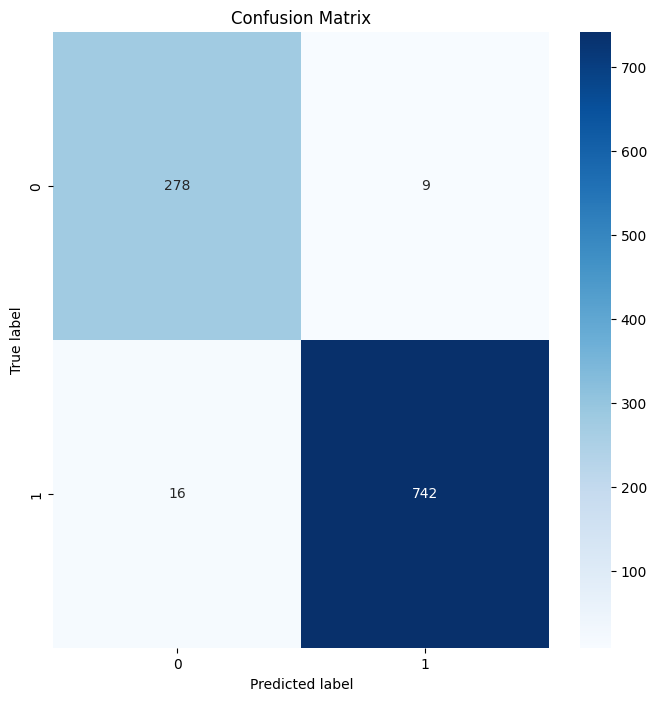

In [29]:
plot_confusion_matrix(model1)

In [46]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objs as go

def plot_roc_curve_with_plotly(model, X_test, Y_test):
    y_pred_probs = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)

    roc_auc = auc(fpr, tpr)

    trace1 = go.Scatter(x=fpr, y=tpr,
                        mode='lines',
                        line=dict(color='darkorange', width=2),
                        name=f'ROC curve (AUC = {roc_auc:.2f})')

    trace2 = go.Scatter(x=[0, 1], y=[0, 1],
                        mode='lines',
                        line=dict(color='navy', width=2, dash='dash'),
                        name='Random')

    layout = go.Layout(title='Receiver Operating Characteristic',
                       xaxis=dict(title='False Positive Rate'),
                       yaxis=dict(title='True Positive Rate'),
                       showlegend=True)

    fig = go.Figure(data=[trace1, trace2], layout=layout)

    fig.show()

In [47]:
plot_roc_curve_with_plotly(model1, X_test, Y_test)


33/33 [==============================] - 2s 47ms/step


## Data Augmentation

In [48]:
original_healthy_path = '/content/drive/My Drive/xrays/HEALTHY'
augmented_healthy_path = '/content/drive/My Drive/AUGMENTED_HEALTHY'
sick_lungs_path = '/content/drive/My Drive/xrays/COVID'


def load_images_and_labels(image_paths, labels):
    images = []
    image_labels = []

    for path, label in zip(image_paths, labels):
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path):
                img = load_img(file_path, target_size=(224, 224))
                img = img_to_array(img)
                img /= 255.0
                images.append(img)
                image_labels.append(label)

    return np.array(images), np.array(image_labels)

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

labels = [0, 0, 1]

images, image_labels = load_images_and_labels(
    [original_healthy_path, augmented_healthy_path, sick_lungs_path],
    labels
)
images = images / 255.0
label_to_index = dict((name, index) for index, name in enumerate(labels))
image_labels = np.array([label_to_index[label] for label in image_labels])


In [50]:
image_paths = [original_healthy_path,augmented_healthy_path,sick_lungs_path]
def convert_to_rgb(image_paths, labels):
    images = []
    image_labels = []

    for path, label in zip(image_paths, labels):
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path) and not filename.startswith('.'):
                img = load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                img = img_to_array(img)
                img = np.repeat(img, 3, axis=2)
                images.append(img)
                image_labels.append(label)

    return np.array(images), np.array(image_labels)

images, image_labels = convert_to_rgb(image_paths,labels)

In [51]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(
    images, image_labels, test_size=test_size, random_state=42
)
print(Y_train)
print(Y_test)

[1 0 0 ... 1 0 1]
[1 0 1 ... 1 1 1]


In [52]:
from tensorflow.keras.callbacks import EarlyStopping

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=base_model.input, outputs=x)
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history2 = model2.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/30
152/152 [==============================] - 13s 83ms/step - loss: 0.3715 - accuracy: 0.9335 - val_loss: 0.0896 - val_accuracy: 0.9686
Epoch 2/30
152/152 [==============================] - 10s 68ms/step - loss: 0.0633 - accuracy: 0.9795 - val_loss: 0.0457 - val_accuracy: 0.9802
Epoch 3/30
152/152 [==============================] - 10s 68ms/step - loss: 0.0414 - accuracy: 0.9870 - val_loss: 0.0387 - val_accuracy: 0.9851
Epoch 4/30
152/152 [==============================] - 10s 68ms/step - loss: 0.0376 - accuracy: 0.9878 - val_loss: 0.0480 - val_accuracy: 0.9851
Epoch 5/30
152/152 [==============================] - 11s 70ms/step - loss: 0.0186 - accuracy: 0.9936 - val_loss: 0.0361 - val_accuracy: 0.9868
Epoch 6/30
152/152 [==============================] - 10s 68ms/step - loss: 0.0181 - accuracy: 0.9932 - val_loss: 0.0537 - val_accuracy: 0.9802
Epoch 7/30
152/152 [==============================] - 10s 69ms/step - loss: 0.0338 - accuracy: 0.9921 - val_loss: 0.0816 - val_accuracy:

In [56]:
model2.save('vgg19_augmented_model.h5')
with open('vgg19_augmented_history.json', 'w') as f:
    json.dump(history1.history, f)

In [59]:
!cp vgg19_augmented_model.h5 "/content/drive/My Drive/"

In [60]:
!cp vgg19_augmented_history.json "/content/drive/My Drive/"

In [61]:
plot_accuracy(history2)


In [62]:
plot_loss(history2)

In [65]:
print_metrics_val(model=model2)

Metrics for validation set:
48/48 [==============================] - 2s 46ms/step
Accuracy: 0.9834765366820886
Precision: 0.9856584093872229
Recall: 0.9818181818181818
F1 Score: 0.9837345478204295


48/48 [==============================] - 3s 55ms/step


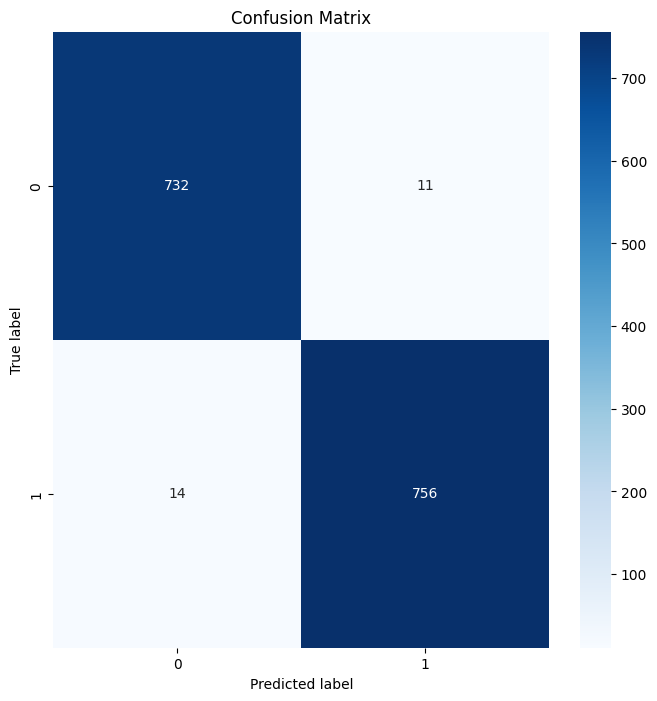

In [63]:
plot_confusion_matrix(model2)

In [64]:
plot_roc_curve_with_plotly(model2, X_test, Y_test)

48/48 [==============================] - 2s 47ms/step
